# Feature Engineering
The feature we want to use to analyze our customers are the features of:
1. Recency: How many days has it been since their last purchases
2. Frequency: How many times have they made a purchase
3. Monetary Value: The total monetary amount that a particular customer has spent

In [6]:
pip install pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [5]:
# Load the cleaned dataset
import os
cleaned_df = pd.read_excel("../data/cleaned_df.xlsx")
pd.set_option('display.precision', 2)
cleaned_df.describe()

,Invoice,Quantity,InvoiceDate,Price,Customer ID
count,406309.00,406309.00,406309,4.06e+05,406309.00
mean,514761.14,13.62,2010-07-01 10:14:25.869572352,2.99e+00,15373.72
min,489434.00,1.00,2009-12-01 07:45:00,1.00e-03,12346.00
25%,502764.00,2.00,2010-03-26 14:01:00,1.25e+00,14006.00
50%,515305.00,5.00,2010-07-09 15:48:00,1.95e+00,15326.00
75%,527104.00,12.00,2010-10-14 17:09:00,3.75e+00,16814.00
max,538171.00,19152.00,2010-12-09 20:01:00,2.95e+02,18287.00
std,14101.61,97.00,NaN,4.29e+00,1677.33


In [8]:
# Create a new column to show the monetary amount that a particular customer spent
cleaned_df["SalesLineTotal"] = (cleaned_df["Quantity"] * cleaned_df["Price"]).round(2)
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
406304,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom,5.90
406305,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
406306,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
406307,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom,7.50


In [9]:
# Calculating RFM metrics: Recency (days since last purchase), Frequency (number of purchases), and Monetary (total spend) per Customer ID

# as_index = False as I don't want to use Custome IDs as my index for resulting dataframe
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index= False)\
    .agg(
        MonetaryValue = ("SalesLineTotal", "sum"),# Sum of total spend
        Frequency = ("Invoice","nunique"),        # Number of unique invoices (assuming each row is one invoice)
        LastInvoiceDate = ("InvoiceDate", "max")  # Most recent InvoiceDate
      )

max_invoice_date = aggregated_df["LastInvoiceDate"].max() # The latest invoice date in the dataset
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days
aggregated_df.head()


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346,169.36,2,2010-06-28 13:53:00,164
1,12347,1323.32,2,2010-12-07 14:57:00,2
2,12348,221.16,1,2010-09-27 14:59:00,73
3,12349,2221.14,2,2010-10-28 08:23:00,42
4,12351,300.93,1,2010-11-29 15:23:00,10


<function matplotlib.pyplot.show(close=None, block=None)>

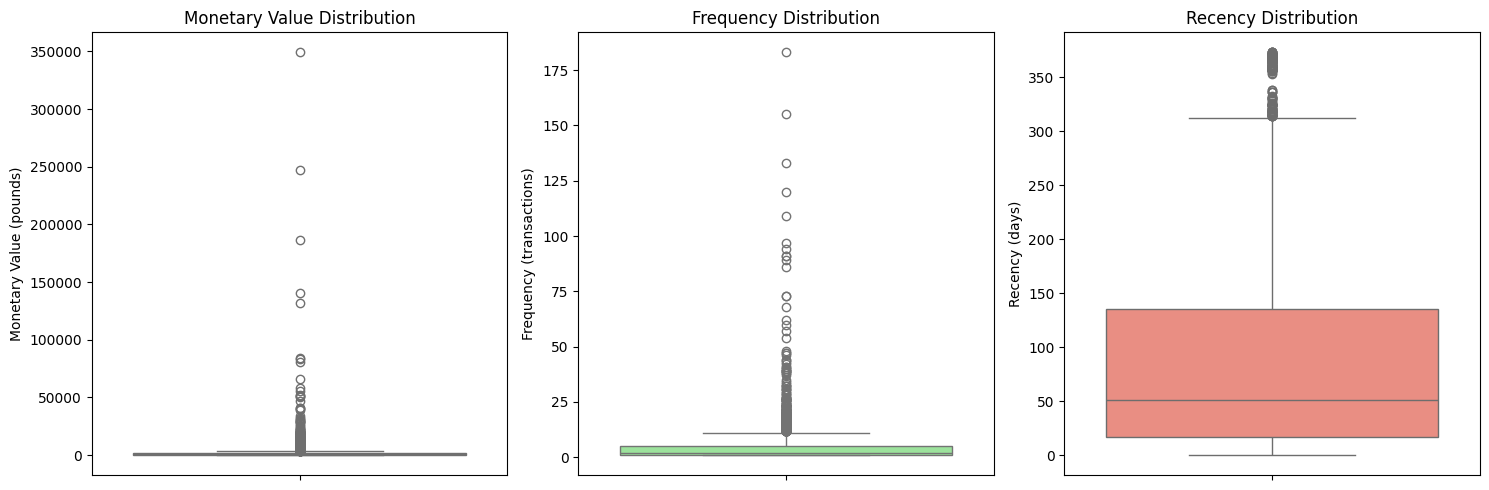

In [10]:
# Plot the Distribution of different features with Boxplots to identify outliers

    ## Why outliers matter => outliers could badly influence our clustering algorithm: 
        ## our centroids may struggle to even find the outliers. If we randomly initialized a particular centroid, it may never find that outlier and we never reach a stability point.
        ## It is important for us to take note of outliers in our dataset and observe if we have any

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1) # Subplot 1 row + 3 columns - 1st graph
sns.boxplot(data = aggregated_df['MonetaryValue'], color = 'skyblue')
plt.title('Monetary Value Distribution')
plt.ylabel('Monetary Value (pounds)')


plt.subplot(1, 3, 2) # 2nd graph
sns.boxplot(data = aggregated_df['Frequency'], color= 'lightgreen')
plt.title('Frequency Distribution')
plt.ylabel('Frequency (transactions)')

plt.subplot(1, 3, 3) # 3rd graph
sns.boxplot(data = aggregated_df['Recency'], color= 'salmon')
plt.title('Recency Distribution')
plt.ylabel('Recency (days)')

plt.tight_layout()
plt.show

### Analysis: 
1. Outlier Interpretation
- The outliers in the Monetary Value and Frequency dimensions are extreme because the majority of data points are at the bottom of the boxplot. In other words, a small number of customers have spent significantly more and made purchases far more frequently than the rest, which skews the distribution and compresses the bulk of the data visually. However, these outliers should not be discarded as they represent high-value customers who are critical to our client's business. Removing them would mean ignoring the most engaged and profitable segment of the customer base, which could lead to misleading insights.

2. Analytical Approach
- Segment the outliers for separate analysis. This allows us to understand the behavior and characteristics of top-tier customers without distorting the clustering of the broader population. 
- Apply K-Means clustering to the remaining data

In [11]:
# Separate out the Outliers - Monetary Value 
M_Q1 = aggregated_df['MonetaryValue'].quantile(0.25) # Get the 25th percentile (Q1)
M_Q3 = aggregated_df['MonetaryValue'].quantile(0.75) # Get the 75th percentile (Q3)
M_IQR = M_Q3 - M_Q1 # Calculate Interquartile range 

# Select rows where 'MonetaryValue' is an outlier (outside 1.5*IQR from Q1 or Q3 ) based on the standard IQR method.
monetary_outliers_df = aggregated_df[ 
	(aggregated_df['MonetaryValue'] > (M_Q3 + 1.5*M_IQR)) | 
	(aggregated_df['MonetaryValue'] < (M_Q1 - 1.5*M_IQR))
]

print('Monetary Value:')
print('M_Q1:', M_Q1)
print('M_Q3:', M_Q3)
print('Monetary Value Interquatile Range (IQR):', M_IQR)
print('Monetary Value Outlier Summary:')
monetary_outliers_df.describe()

Monetary Value:
M_Q1: 307.56
M_Q3: 1704.29
Monetary Value Interquatile Range (IQR): 1396.73
Monetary Value Outlier Summary:


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [12]:
# Separate out the Outliers - Frequency Value
F_Q1 = aggregated_df['Frequency'].quantile(0.25) # Get the 25th percentile (Q1)
F_Q3 = aggregated_df['Frequency'].quantile(0.75) # Get the 75th percentile (Q3)
F_IQR = F_Q3 - F_Q1 # Calculate interquantile range 

# Select rows where 'Frequency' is an outlier (outside 1.5*IQR from Q1 or Q3 ) based on the standard IQR method.
frequency_outliers_df = aggregated_df[
	(aggregated_df['Frequency'] > (F_Q3 + 1.5*F_IQR)) | 
	(aggregated_df['Frequency'] < (F_Q1 - 1.5*F_IQR))
]

print('Monetary Value:')
print('F_Q1:', F_Q1)
print('F_Q3:', F_Q3)
print('Frequency Interquatile Range (IQR):', F_IQR)
print('Frequency Outlier Summary:')
frequency_outliers_df.describe()

Monetary Value:
F_Q1: 1.0
F_Q3: 5.0
Frequency Interquatile Range (IQR): 4.0
Frequency Outlier Summary:


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


In [13]:
# Create a dataframe without outliers in monetary values and frequency (noted that some outliers may overlap between the two categories.)

# Leverage pandas to extract records where the index values are not in either the monetary or frequency outlier dataframe indices
non_outliers_df = aggregated_df[
    (~aggregated_df.index.isin(monetary_outliers_df.index)) &
    (~aggregated_df.index.isin(frequency_outliers_df.index))
]

non_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


<function matplotlib.pyplot.show(close=None, block=None)>

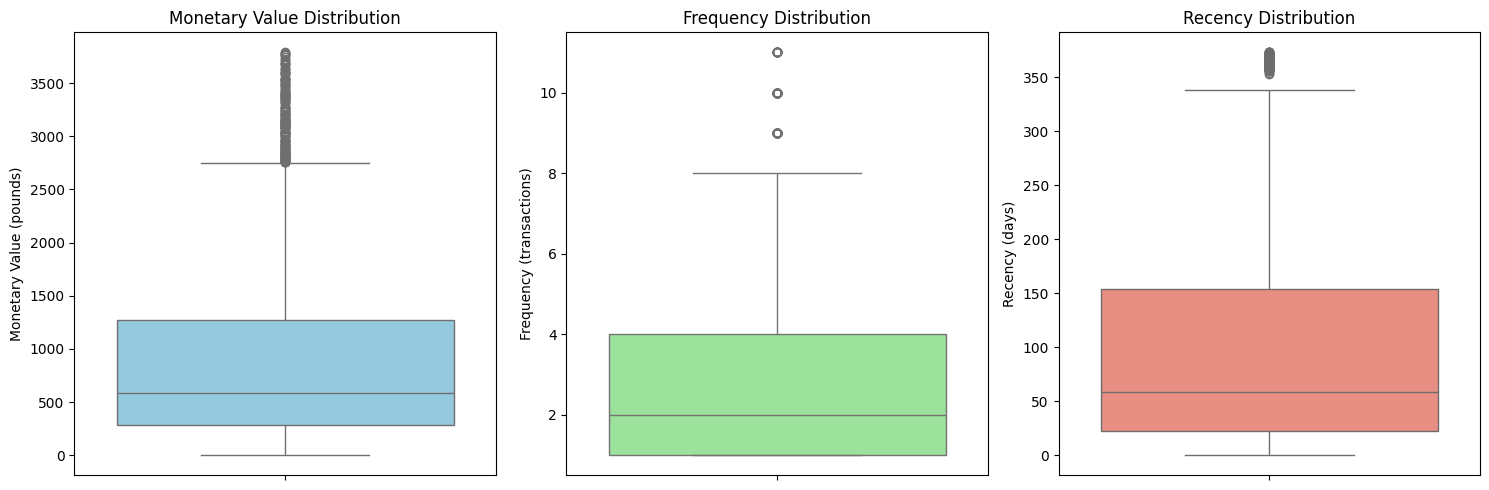

In [14]:
# Plot the Distribution of different features with Boxplots using non-outliers data frame

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1) # Subplot 1 row + 3 columns - 1st graph
sns.boxplot(data = non_outliers_df['MonetaryValue'], color = 'skyblue')
plt.title('Monetary Value Distribution')
plt.ylabel('Monetary Value (pounds)')


plt.subplot(1, 3, 2) # 2nd graph
sns.boxplot(data = non_outliers_df['Frequency'], color= 'lightgreen')
plt.title('Frequency Distribution')
plt.ylabel('Frequency (transactions)')

plt.subplot(1, 3, 3) # 3rd graph
sns.boxplot(data = non_outliers_df['Recency'], color= 'salmon')
plt.title('Recency Distribution')
plt.ylabel('Recency (days)')

plt.tight_layout()
plt.show

### Comment 
Even after we rescaled the data, there are still outliers, but it is okay as the outliers are now a lot more tolerable

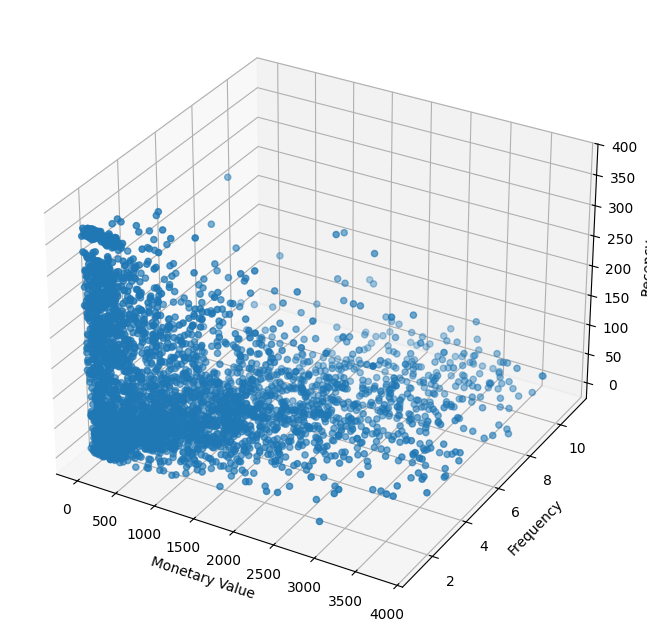

In [15]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(projection = '3d')
scatter = ax.scatter(non_outliers_df['MonetaryValue'], non_outliers_df['Frequency'], non_outliers_df['Recency'])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

plt.show()

## Analysis:
 These features are on very different scales (0–4000, 0–10, 0–400). If we use the raw values, K-means clustering will be dominated by the monetary value dimension, since it has the largest scale. K-means is sensitive to feature scaling, and centroids will shift disproportionately toward high-value features. To avoid this bias and ensure that recency, frequency, and monetary value are treated with equal importance, we should standardize or normalize the features before clustering

# Standard Scaling
Standard Scaling transforms the features of data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the analysis:
$$
z = \frac{x - \mu}{\sigma}
$$
Where:  
- \( z \) is the standardized value  
- \( x \) is the original value  
- $\mu$ is the mean of the feature  
- $\sigma$ is the standard deviation of the feature   

In [16]:
# Initialize the StandardScaler and apply it to the selected features to standardize them (mean=0, std=1)
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[['MonetaryValue', 'Frequency', 'Recency']])
scaled_data

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.53551441, -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488782,  0.50659348, -0.81634357]], shape=(3809, 3))

In [17]:
# Turn array outcome into a dataframe
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=('MonetaryValue','Frequency','Recency'))
scaled_data_df

,MonetaryValue,Frequency,Recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


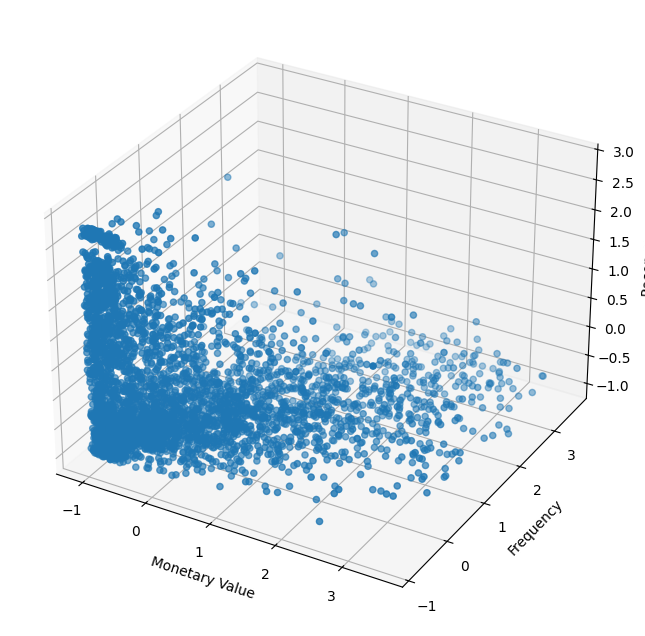

In [18]:
# Plot the normalized dataset 
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(projection = '3d')
scatter = ax.scatter(scaled_data_df['MonetaryValue'], scaled_data_df['Frequency'], scaled_data_df['Recency'])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

plt.show()

### Comment
It appears that the 3D shape hasn't changed much, but our scale has changed: our monetary value, frequency, and recency are now on comparable scales, varying between -1 and 1. It's good to move on to Kmeans Clustering

# K-means Clustering


### How Does K-means Clustering Work?


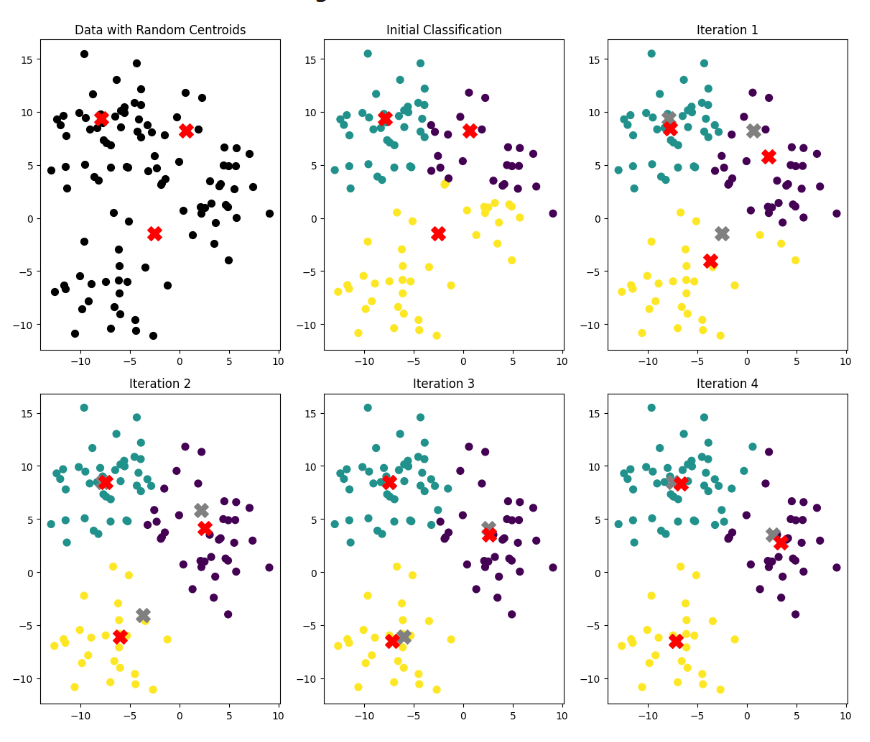


K-means clustering is a method that divides customers into groups (clusters) so that customers within the same group are as similar as possible, based on features like spending habits and purchase frequency. The algorithm works by placing a center point (centroid) for each group, assigning each customer to the nearest centroid, and then moving the centroids to better fit the data. This process repeats until the centroids are stable and the groups are well-formed.


To determine the best number of clusters (K), we use the 'elbow method.' We run K-means with different values of K and calculate the total within-cluster sum of squares (inertia) for each. As K increases, inertia decreases, but after a certain point, the improvement becomes marginal. The 'elbow' point on the graph is where adding more clusters does not significantly reduce inertia. This is considered the optimal number of clusters, as it balances grouping quality and simplicity.


In summary, K-means finds the best way to group customers by minimizing the average distance from each customer to their cluster center. The elbow method helps us choose a K where the clusters are meaningful and not overly complex.


### Elbow Method

This technique involves plotting the within-cluster sum of squares (WCSS) against the number of clusters and identifying the "elbow" point where adding more clusters does not significantly reduce WCSS, indicating a suitable number of clusters for K-means.

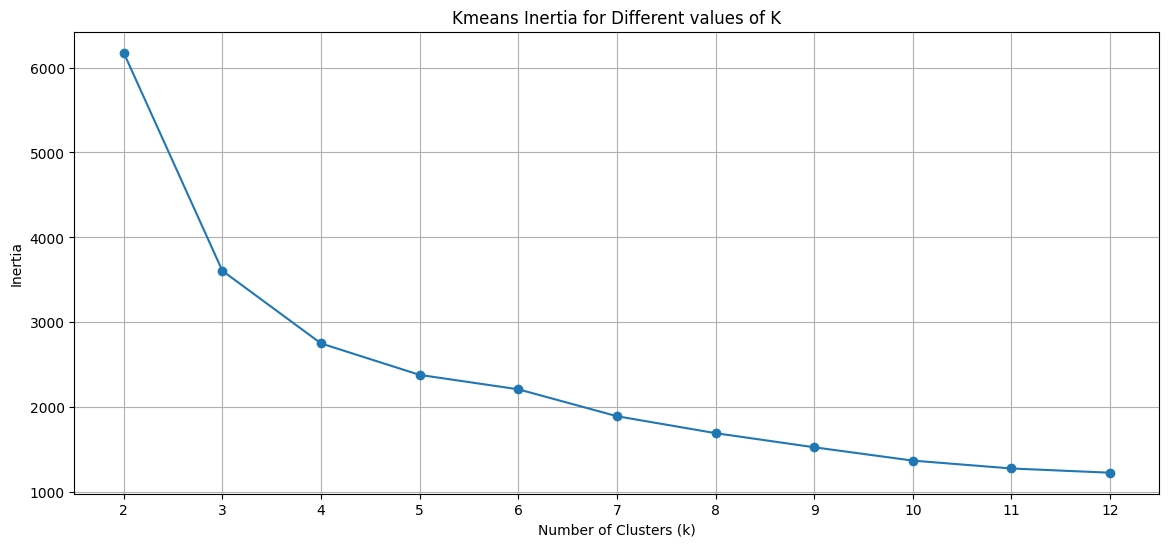

In [19]:
# Applying Elbow Method

max_k = 12 # Select a Max K value
inertia = [] # create inertia list
k_values = range(2, max_k + 1) # +1 here because range keyword only goes up to one minus the maximum here so it is exclusive of the k_max (12) we specified

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state = 42, max_iter=1000)
    # random state helps generate repeatable results and this can be any fixed number. 
    # Reason for setting random_state: initial assignment of centroids is random so we want this to be repeatable and somewhat fair
    # max_iter means how many iterations to go through before stopping the process of moving the centroids of our clusters

    kmeans.fit_predict(scaled_data_df) # fit k means to the data and predict on the data

    inertia.append(kmeans.inertia_) # # Append the inertia (sum of squared distances from each point to its cluster centroid) for this K to the list.
    # kmeans.inertia_ is the sum of squared distances from each data point to its assigned cluster center (centroid).
                        # This value is used to evaluate how well the data points fit within their clusters. The lower the inertia, the tighter the clusters.  
                        
plt.figure(figsize=(14,6))
plt.plot(k_values, inertia, marker='o')
plt.title('Kmeans Inertia for Different values of K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show() 

### Comment
The inertia value starts off pretty high and rapidly decline and then slowly lowers down. The technique of the elbow method is determing the point at which the elbow of the curve appears. In this case, 4 and 5 show stability in how many clusters we should allocate. To determine the four and five clusters, we are goin to use another metric, silhouetter score.

# Silhouette Score

The Silhouette Score measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 (incorrect clustering, or there are lots of overlap) to +1 (well-clustered, or more distinct clusters).

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

You may also want to use normal parentheses instead of LaTeX function notation for clarity, but both are acceptable.

Where:
- $a$($i$) = average distance from the point to all other points in the same cluster (intra-cluster distance)
- $b$($i$) = average distance from the point to all points in the nearest different cluster (nearest-cluster distance)
- $s$($i$) = silhouette score for a single sample $i$ 

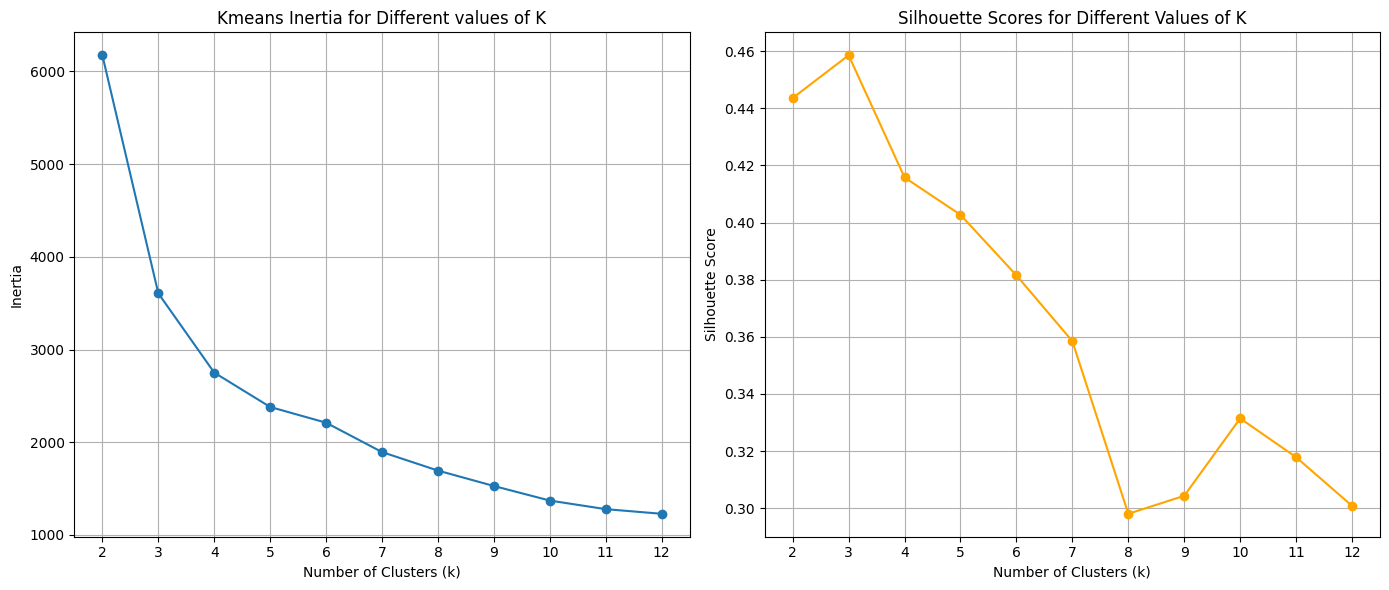

In [20]:
max_k = 12 
inertia = [] 
silhoutte_scores = []
k_values = range(2, max_k + 1) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state = 42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df) # Capture the cluster labels. This will give us cluster numbers each time we run the Kmeans algorithm and run this predict on top of our scale data

    sil_score = silhouette_score(scaled_data_df, cluster_labels) # run the Silhouttee Score equation
    
    silhoutte_scores.append(sil_score)
    
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Kmeans Inertia for Different values of K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

### Comment

The k=4 clustering has a slightly higher silhouette score than k=5, so we select k=4 for our analysis. A higher silhouette score indicates more distinct and well-separated clusters, meaning less potential overlap between groups. This makes k=4 the optimal choice for meaningful segmentation in this context.

Note: Generally, using less clusters is better because it reduces the complexity of further analysis. For example, 15 clusters vs 4 clusters, that means you will have to interpret 15 datasets, instead of 4.

In [21]:
# Initialize KMeans with 4 clusters, a fixed random state for reproducibility, and a higher max_iter for convergence
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

# Fit KMeans to the scaled data and get the cluster labels for each data point
cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([1, 0, 2, ..., 1, 0, 0], shape=(3809,), dtype=int32)

In [22]:
# Add the cluster labels as a new column 'Clusters' to the non_outliers_df dataframe
non_outliers_df['Clusters'] = cluster_labels

non_outliers_df

C:\Users\JohnP\AppData\Local\Temp\ipykernel_15180\3281084694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df['Clusters'] = cluster_labels


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Clusters
0,12346,169.36,2,2010-06-28 13:53:00,164,1
1,12347,1323.32,2,2010-12-07 14:57:00,2,0
2,12348,221.16,1,2010-09-27 14:59:00,73,2
3,12349,2221.14,2,2010-10-28 08:23:00,42,0
4,12351,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4280,18283,641.77,6,2010-11-22 15:30:00,17,0
4281,18284,411.68,1,2010-10-04 11:33:00,66,2
4282,18285,377.00,1,2010-02-17 10:24:00,295,1
4283,18286,1246.43,2,2010-08-20 11:57:00,111,0


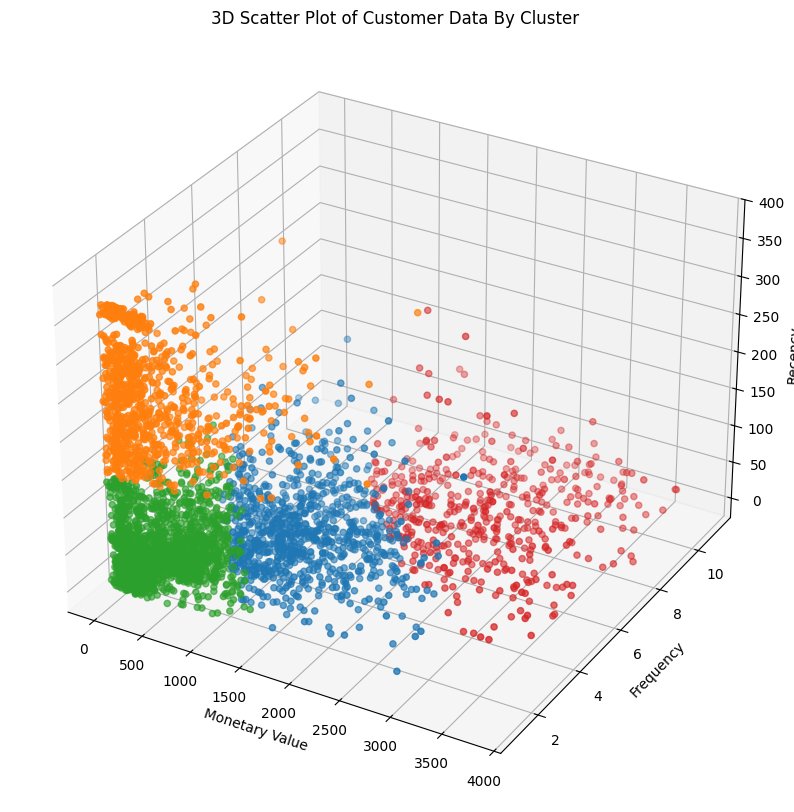

In [23]:
# Plotting the clusters

cluster_colors = {0: '#1f77b4',
                  1: '#ff7f0e',
                  2: '#2ca02c',
                  3: '#d62728'}
colors = non_outliers_df['Clusters'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'],
                     non_outliers_df['Frequency'],
                     non_outliers_df['Recency'],
                     c= colors,
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data By Cluster')

plt.show()

### Comment
This looks very good:

**Insights from the 3D Cluster Plot:**
- The clusters are well-separated in the 3D space, indicating that the K-means algorithm has successfully grouped customers with similar purchasing behaviors together.

### 📊 Cluster Overview

Each cluster represents a distinct customer segment based on their **Monetary Value**, **Frequency**, and **Recency** of purchases:

| Label | Cluster Color | Characteristics                                      |
|-------|----------------|------------------------------------------------------|
| 0     | 🔵 Blue         | Middle Range across all three dimensions             |
| 1     | 🟠 Orange       | Low Monetary Value, Average Frequency, Moderate Recency |
| 2     | 🟢 Green        | Low Monetary Value, Low Frequency, High Recency      |
| 3     | 🔴 Red          | High Monetary Value, High Frequency, Low Recency     |

- Next step: interpreting our clusters a bit more rigorously

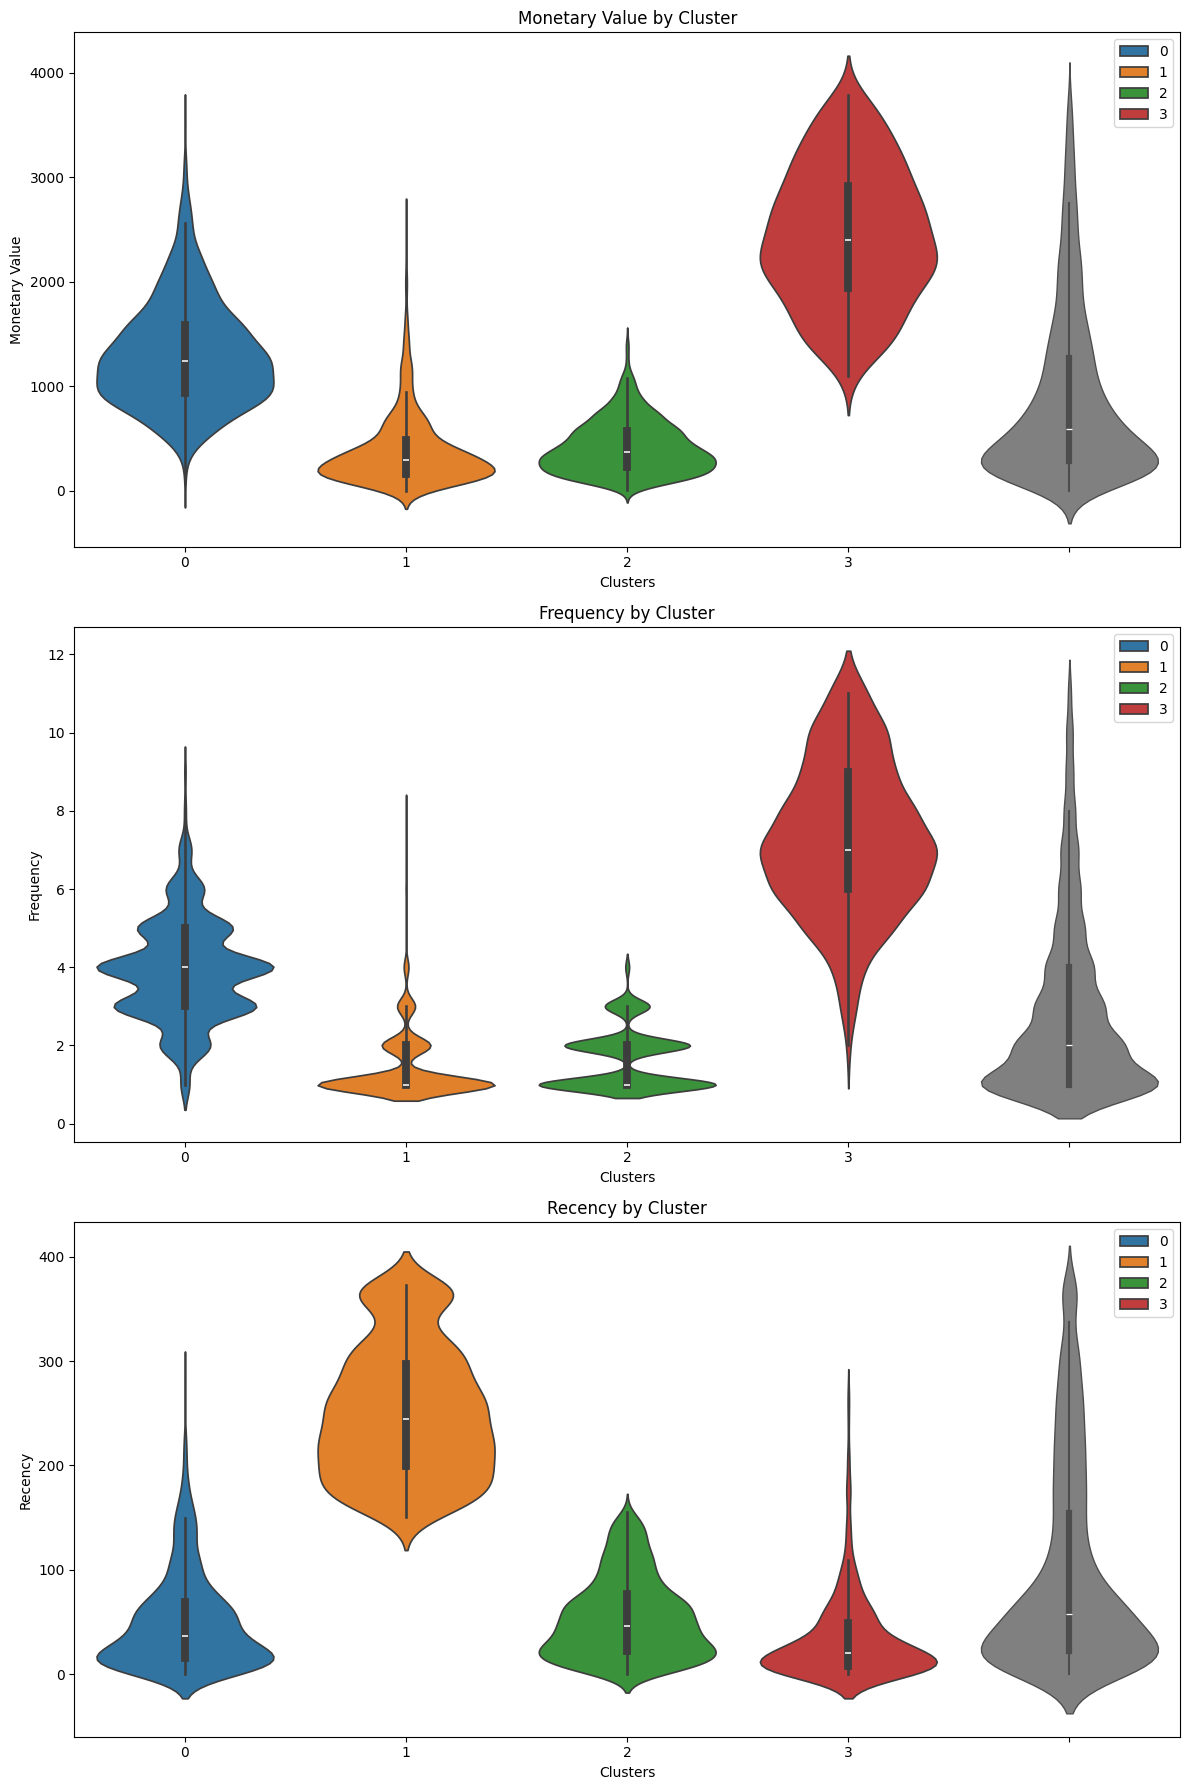

In [24]:
# Plot the clusters in a boxplot
plt.figure(figsize = (12,18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Clusters'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df['Clusters'])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Clusters'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df['Clusters'])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Clusters'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df['Clusters'])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()


# Interpretation & Recommendations

#### Cluster 0 (Blue): Consistent Buyers - Retain
- Rationale: This group consists of valuable customers who make repeat purchases, even if their activity isn’t always recent. They’ve shown consistent behavior over time, making them ideal candidates for retention strategies.
- Recommended Approach: Strengthen engagement through tailored loyalty programs, exclusive offers, and ongoing communication to reinforce their connection with the brand and encourage continued spending.

#### Cluster 1 (Orange): Low-Engagement Buyers - Reactivate
- Rationale: This cluster includes customers with minimal purchase history and low recent activity. They currently contribute less value, but have potential if reactivated.
- Recommended Strategy: Launch personalized outreach efforts—such as limited-time offers, tailored promotions, and reminder messaging—to reignite interest and motivate purchases.

#### Cluster 2 (Green): Early-Stage Buyers – Nurture for Growth
- Rationale: This segment includes customers with low overall value and limited purchase history, but they’ve recently engaged. Many may be new to the brand and show potential for deeper involvement.
- Recommend Stratety: Prioritize relationship-building through standout customer service and thoughtful incentives to encourage more frequent purchases.

#### Cluster 3 (Red): High-Value Loyalists – Reward and Retain
- Rationale: This cluster includes loyal customers, who have made frequent high-value purchases and continue to show strong engagement. Their loyalty drives significant value, making them critical to long-term success. Thus, rewarding their loyalty is key to maintaining their engagement.
- Recommend Stratety: Double down on appreciation through premium loyalty programs, exclusive perks, and personalized recognition. Keep their experience exceptional to reinforce satisfaction and prevent churn.

### Customer Segmentation Summary

| Label | Cluster Color | Segment Name               | Rationale                                                                 | Recommended Strategy                                                                 |
|-------|----------------|----------------------------|---------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| 0     | 🔵 Blue         | Consistent Buyers – Retain | Repeat purchasers with consistent behavior, though not always recent      | Loyalty programs, exclusive offers, and ongoing communication                        |
| 1     | 🟠 Orange       | Low-Engagement Buyers – Reactivate | Minimal history and low activity, but potential if re-engaged         | Personalized outreach, limited-time offers, and reminder messaging                   |
| 2     | 🟢 Green        | Early-Stage Buyers – Nurture | Recently engaged, low value and frequency; likely new customers           | Relationship-building, standout service, and thoughtful incentives                   |
| 3     | 🔴 Red          | High-Value Loyalists – Reward | Frequent, high-value purchases and strong engagement; critical segment    | Premium loyalty programs, exclusive perks, and personalized recognition              |

Note:
- Noted that we still have outlier groups including: monetary_outliers_df and frequency_outliers_df. Since some of the monetary value outliers could also be frequency outliers, we want to take that into account.
- Approach: Form 3 new clusters: pure monetary value outlier, pure frequency outlier, and mix-outliers

In [25]:
# Find indexes where monetary value outlier overlap frequency outlier
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)
monetary_n_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

# From monetary outlier dataframe, extract only monetary value outliers
monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)

# From frequency outlier dataframe, extract only frequency outliers
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)

# Assign Cluster group ID for each
monetary_only_outliers['Clusters'] = -1
frequency_only_outliers['Clusters'] = -2
monetary_n_frequency_outliers['Clusters'] = -3

# Combine all 3 clusters for further analysis
outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_n_frequency_outliers])

outlier_clusters_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Clusters
9,12357,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
4235,18223,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231,4791.80,23,2010-10-29 14:17:00,41,-3


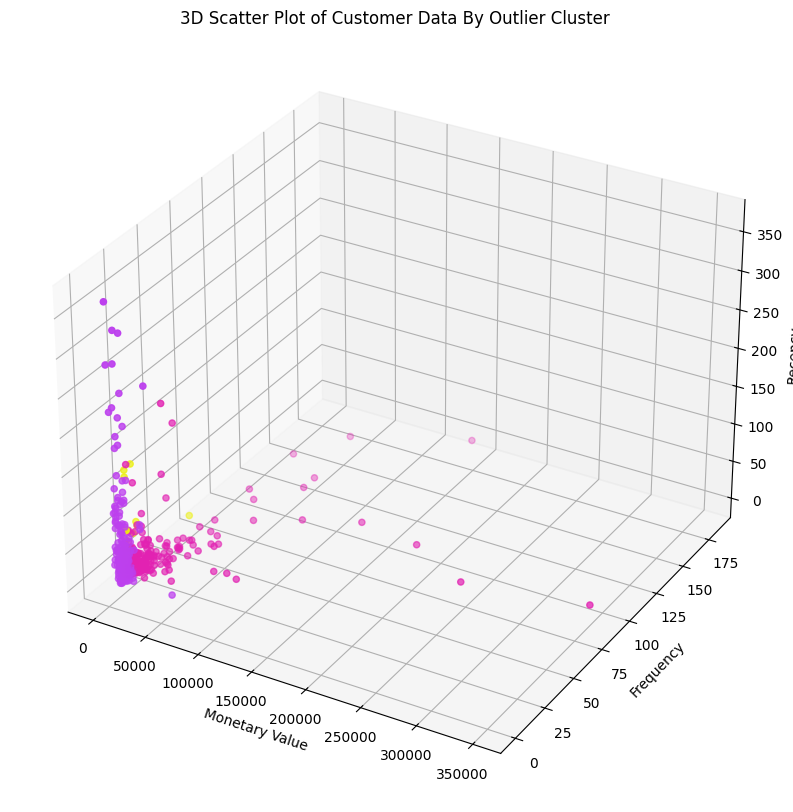

In [26]:
# Plot outliers Clusters 
cluster_colors = {-1: "#bd40ee",
                  -2: "#ecf00e",
                  -3: "#e222b2"}
colors = outlier_clusters_df['Clusters'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Create a 3D scatter plot using the outlier clusters dataframe
scatter = ax.scatter(outlier_clusters_df['MonetaryValue'],
                     outlier_clusters_df['Frequency'],
                     outlier_clusters_df['Recency'],
                     c = colors,
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data By Outlier Cluster')

plt.show()

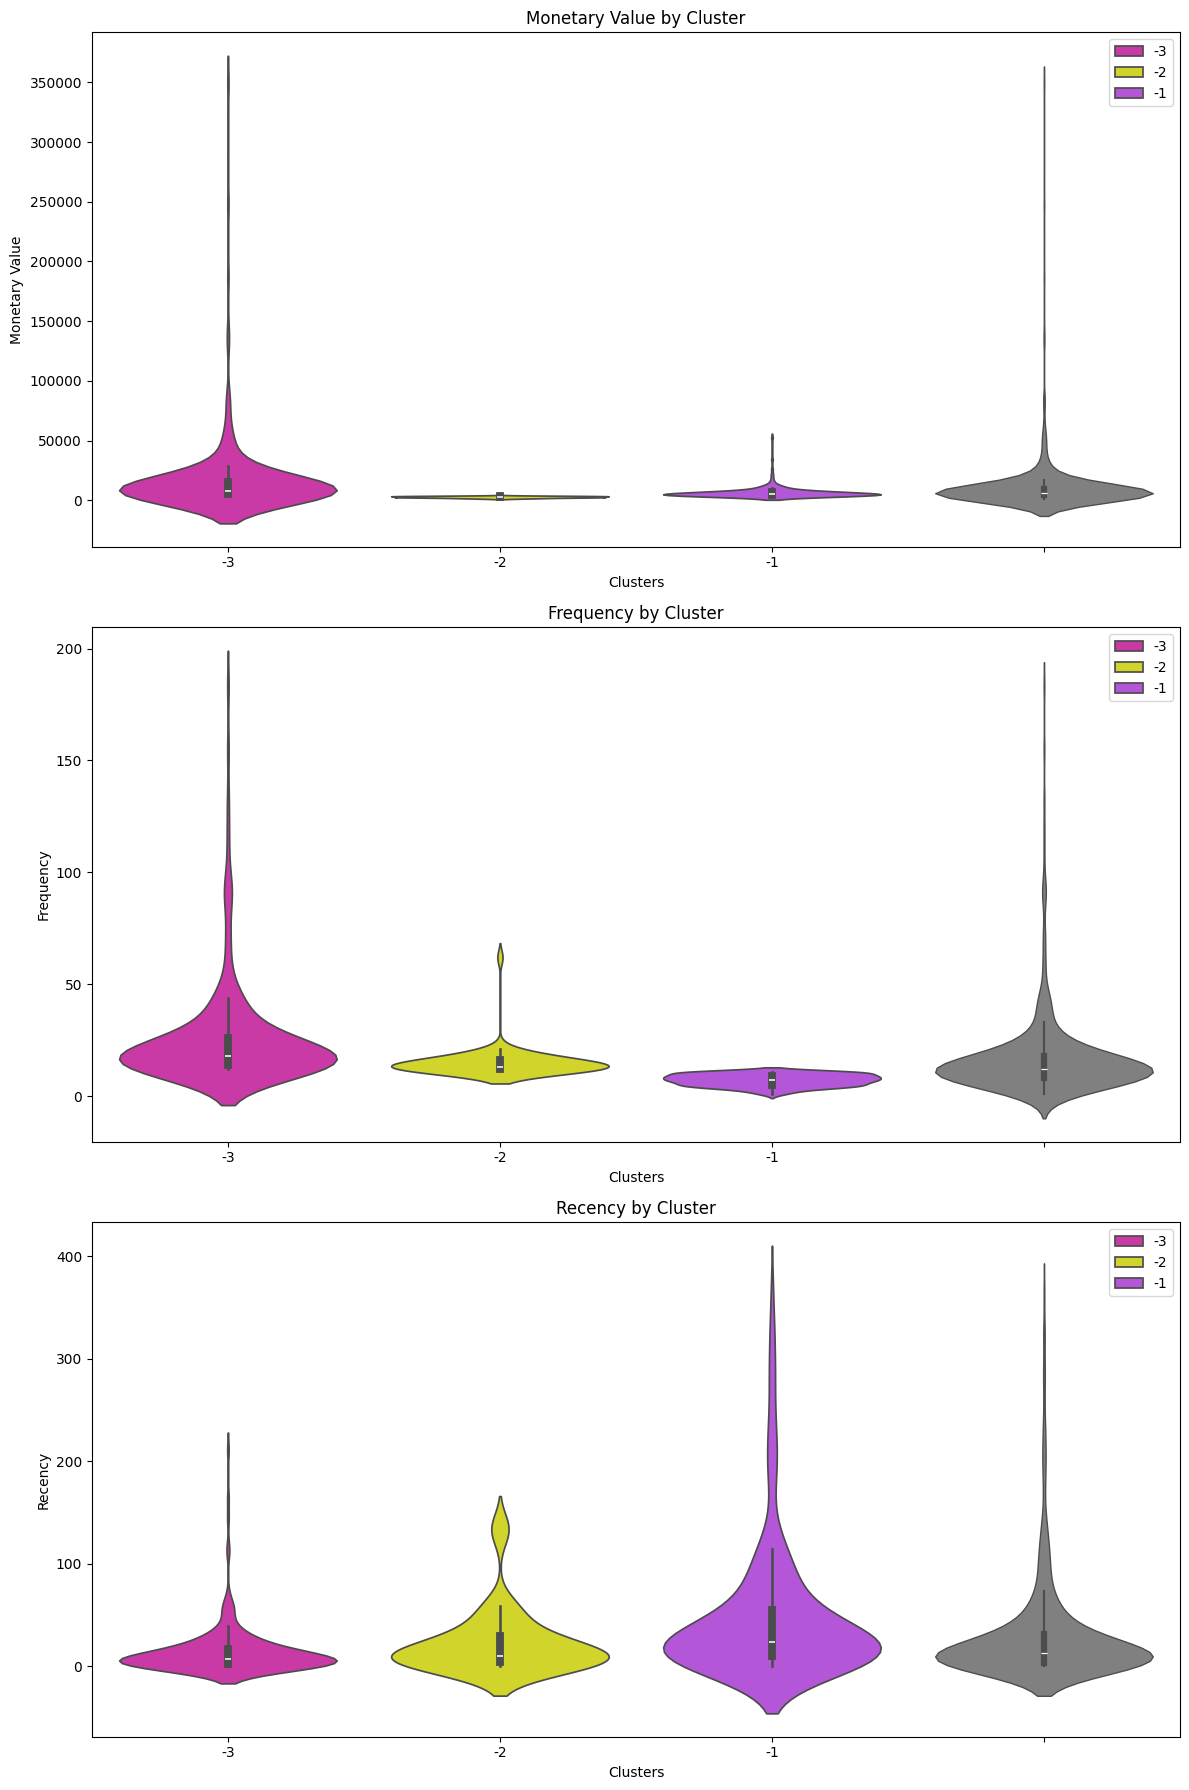

In [27]:
# Plot outliers Clusters 
plt.figure(figsize = (12,18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Clusters'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df['Clusters'])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Clusters'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df['Clusters'])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Clusters'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df['Clusters'])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

# Outlier Cluster Interpretation & Recommendation

#### Cluster -1 (Monetary Only Outliers): High-Spend, Low-Frequency and High Recency – Pamper Strategically
- Rationale: These customers spend significantly but don’t purchase often. Their high transaction value makes them important to retain, even if their engagement is occasional.
- Recommend Strategy: Focus on maintaining their loyalty by curating exclusive offers, concierge-style service, and personalized outreach. Use predictive modeling to anticipate next purchase and nudge gently.

#### Cluster -2 (Frequency Outliers): High-Frequency, Low-Spend, Low Recency – Upsell with Value
- Rationale: Frequent buyers but limited order value. These customers are consistently engaged but might be budget conscious and might benefit from upselling opportunities. 
- Recommend Stategy: Introduce tiered loyalty programs, product bundles, and cross-sell nudges to encourage higher spending per visit, given their frequent engagement. Highlight value and convenience to encourage larger baskets.

#### Cluster -3 (Monetary & Frequency Outliers) High-Spend, High-Frequency, Low Recency – Delight and Elevate
- Rational: These buyers are top-tier customers, with extreme spending and frequent purchases. These are customers that always require attention
- Recommend Strategy: Launch VIP tiers, early access to launches, personalized thank-you campaigns or exclusive offers to maintain their loyalty and encourage continued engagement. Also, consider co-creation opportunities or feedback loops to deepen engagement.

### Outlier Customers Segmentation Summary

| Label | Cluster Color | Segment Name                  | Rationale                                                                 | Recommended Strategy                                                                 |
|-------|----------------|-------------------------------|---------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| -1    | 🟣 Purple       | High-Spend Infrequents – Pamper | Significant spenders with low purchase frequency and high recency; valuable but sporadic | Curate exclusive offers, concierge-style service, and personalized outreach. Use predictive modeling to gently re-engage. |
| -2    | 🟡 Yellow       | Frequent Frugals – Upsell       | Highly engaged with frequent purchases but low spend; low recency suggests recent activity | Introduce tiered loyalty programs, product bundles, and cross-sell nudges. Emphasize value to grow basket size. |
| -3    | 💗 Magenta      | Top-tier – Delight         | Top-tier customers with high spend and frequency; low recency indicates strong recent engagement | Launch VIP tiers, early access to launches, and personalized thank-you campaigns. Explore co-creation and feedback loops. |

In [28]:
# Map strategic labels to cluster IDs to support audience-friendly visualization and storytelling

cluster_labels = {
    0: 'RETAIN',
    1: 'RE-ENGAGE',
    2: 'NURTURE',
    3: 'REWARD',
    -1: 'PAMPER',
    -2: 'UPSELL',
    -3: 'DELIGHT'    
}

full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df['ClusterLabel'] = full_clustering_df['Clusters'].map(cluster_labels)
full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Clusters,ClusterLabel
0,12346,169.36,2,2010-06-28 13:53:00,164,1,RE-ENGAGE
1,12347,1323.32,2,2010-12-07 14:57:00,2,0,RETAIN
2,12348,221.16,1,2010-09-27 14:59:00,73,2,NURTURE
3,12349,2221.14,2,2010-10-28 08:23:00,42,0,RETAIN
4,12351,300.93,1,2010-11-29 15:23:00,10,2,NURTURE
...,...,...,...,...,...,...,...
4235,18223,7516.31,12,2010-11-17 12:20:00,22,-3,DELIGHT
4236,18225,7545.14,15,2010-12-09 15:46:00,0,-3,DELIGHT
4237,18226,6650.83,15,2010-11-26 15:51:00,13,-3,DELIGHT
4241,18231,4791.80,23,2010-10-29 14:17:00,41,-3,DELIGHT


In [29]:
# Count the number of customers in each cluster label (helps assess cluster size and distribution)
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()

# Normalize MonetaryValue to align its scale with Recency and Frequency for balanced visualization and comparison
full_clustering_df['MonetaryValue per 100 pounds'] = full_clustering_df['MonetaryValue'] /100.00

# Calculate the average Recency, Frequency, and MonetaryValue (normalized) for each cluster
# This summarizes behavioral traits of each segment for strategic analysis
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency','Frequency','MonetaryValue per 100 pounds']].mean()

print('Number of customers in each cluster: ')
print(cluster_counts)

print('Feature summary of each cluster')
feature_means.columns = ['Recency (days)', 'Frequency (orders)', 'MonetaryValue per 100 pounds']
feature_means


Number of customers in each cluster: 
ClusterLabel
NURTURE      1499
RETAIN        914
RE-ENGAGE     902
REWARD        494
DELIGHT       226
PAMPER        197
UPSELL         53
Name: count, dtype: int64
Feature summary of each cluster


,Recency (days),Frequency (orders),MonetaryValue per 100 pounds
ClusterLabel,,,
DELIGHT,14.45,25.87,171.48
NURTURE,54.07,1.64,4.18
PAMPER,47.91,7.19,64.98
RE-ENGAGE,251.17,1.43,3.85
RETAIN,49.73,3.91,13.09
REWARD,33.89,7.24,24.36
UPSELL,23.08,15.04,27.35


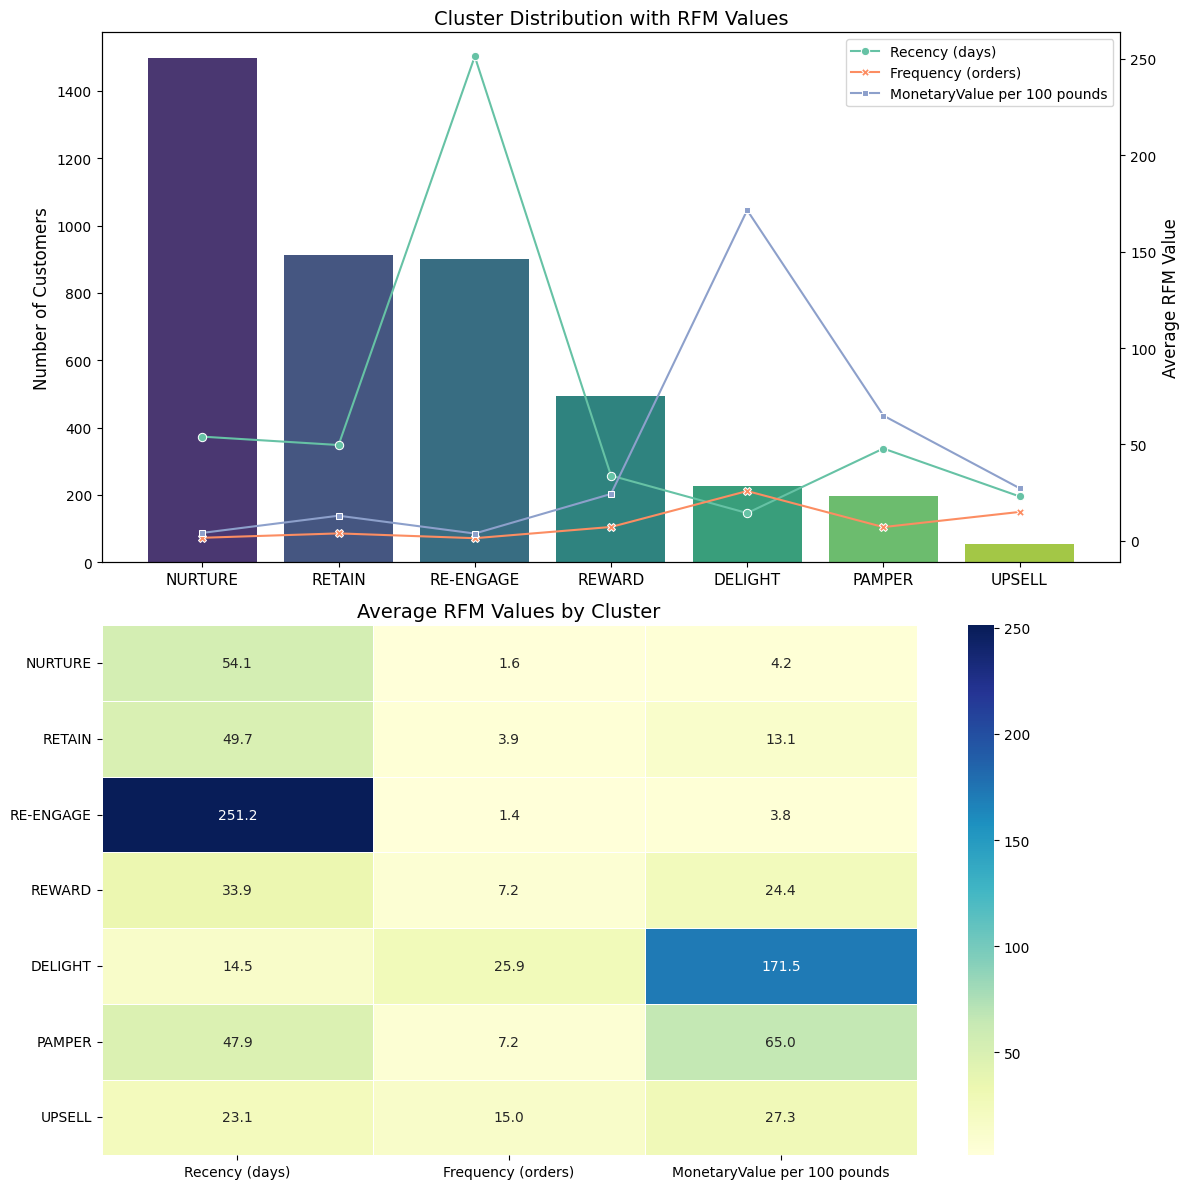

In [33]:
# Set up the overall layout: 2 rows, 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1]})

# --- TOP CHART: Bar + Line ---
# Bar chart for cluster counts
sns.barplot(x=cluster_counts.index, 
            y=cluster_counts.values, 
            hue=cluster_counts.index,  # explicitly set hue
            ax=ax1, 
            palette='viridis',
            legend=False)

ax1.set_ylabel('Number of Customers', fontsize=12)
ax1.set_xlabel('', fontsize=12)
ax1.set_xticks(range(len(cluster_counts.index)))
ax1.set_xticklabels(cluster_counts.index, fontsize=11)

# Line chart for average RFM values
ax3 = ax1.twinx()
sns.lineplot(data=feature_means, 
             ax=ax3, 
             palette='Set2',
             
             markers=True, 
             dashes=False)
ax3.set_ylabel('Average RFM Value', fontsize=12)
ax1.set_title('Cluster Distribution with RFM Values', fontsize=14)
# --- BOTTOM CHART: Heatmap ---
# Heatmap of average RFM values by cluster
sorted_clusters = cluster_counts.sort_values(ascending=False).index.tolist()
feature_means_sorted = feature_means.loc[sorted_clusters]

sns.heatmap(feature_means_sorted,  # clusters as rows
            annot=True, 
            fmt=".1f", 
            cmap="YlGnBu", 
            linewidths=0.5, 
            ax=ax2,
            cbar_kws={'label': ''})

ax2.set_title('Average RFM Values by Cluster', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## Analysis:
Key Findings:
- NURTURE (1,499 customers): Largest segment with low frequency and moderate recency. These are low-value, semi-active customers who may respond to reactivation campaigns.

- RETAIN and RE-ENGAGE (~900 each): RETAIN shows promising frequency and spend, while RE-ENGAGE has extremely high recency and low value, indicating churn risk. These segments require differentiated retention strategies.

- REWARD, DELIGHT, and PAMPER: Smaller but high-value clusters with strong frequency and monetary contributions. These are loyal customers who merit personalized incentives and exclusive offers.

- UPSELL: No current customers, yet it represents the highest potential in frequency and spend. This gap suggests a missed targeting opportunity, ideal for lookalike modeling or premium acquisition campaigns.

## Strategic Implications:
- Prioritize REWARD and UPSELL for the coming quarter growth initiatives.

- Launch win-back efforts for RE-ENGAGE using tailored messaging.

- Develop loyalty programs for DELIGHT and PAMPER to reinforce retention.

- Monitor NURTURE for early churn signals and test low-cost engagement tactics.